In [1]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Arguments
images = "faces"
batch_size = 1
confidence = 0.5
nms_thesh = 0.4

det = "det_faces"
cfgfile = "cfg/yolov3.cfg"
weightsfile = "weights/yolov3.weights"
reso = 416

start = 0
CUDA = torch.cuda.is_available()

In [4]:
num_classes = 80    #For COCO
classes = load_classes("data/coco.names")

In [5]:
#Set up the neural network
print("Loading network.....")
model = Darknet(cfgfile)
model.load_weights(weightsfile)
print("Network successfully loaded")

model.net_info["height"] = reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

#Set the model in evaluation mode
model.eval()

start_time = time.time()

Loading network.....
Network successfully loaded


In [6]:
# Detection phase
read_dir_time = time.time()    #checkpoint used to measure time
# Load image directories
try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    
if not os.path.exists(det):
    os.makedirs(det)
    
read_dir_time = time.time() - read_dir_time

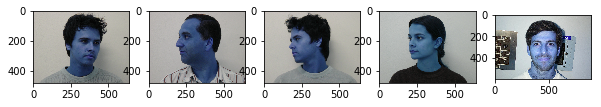

In [7]:
load_batch_time = time.time()    
# Load images
#Numpy arrays for images in BGR
loaded_ims = [cv2.imread(x) for x in imlist]

#PyTorch Variables for images
im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))

#List containing dimensions of original images
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

if CUDA:
    im_dim_list = im_dim_list.cuda()
    
#Create the batches
leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                       len(im_batches))]))  for i in range(num_batches)]
    
load_batch_time = time.time() - load_batch_time

# Plot images
fig = plt.figure(figsize=(10, 10))
n = min(5, len(loaded_ims))
for i in range(n):
    fig.add_subplot(1,n, i + 1)
    plt.imshow(loaded_ims[i])
plt.show()


In [9]:
output = torch.empty(0)
no_detections = 0
det_loop_time = time.time()
#Loop through batches
for i, batch in enumerate(im_batches):
    start = time.time()
    if CUDA:
        batch = batch.cuda()

    with torch.no_grad():   #autograd will not compute gradients in forward pass
        prediction = model(Variable(batch), CUDA)
        prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if len(prediction)==0:    #Objects not detected
        no_detections += 1
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()  #make sure CUDA returns control to CPU only after GPU work is done

        
det_loop_time = time.time() - det_loop_time

if len(output)==0:
    print ("No detections were made")

/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


18.jpg               predicted in  0.514 seconds
Objects Detected:    person
----------------------------------------------------------
133.jpg              predicted in  0.061 seconds
Objects Detected:    person
----------------------------------------------------------
15.jpg               predicted in  0.058 seconds
Objects Detected:    person
----------------------------------------------------------
85.jpg               predicted in  0.058 seconds
Objects Detected:    person
----------------------------------------------------------
157.jpg              predicted in  0.061 seconds
Objects Detected:    person
----------------------------------------------------------
107.jpg              predicted in  0.060 seconds
Objects Detected:    person
----------------------------------------------------------
168.jpg              predicted in  0.060 seconds
Objects Detected:    person
----------------------------------------------------------
134.jpg              predicted in  0.060 seconds

171.jpg              predicted in  0.059 seconds
Objects Detected:    person refrigerator
----------------------------------------------------------
72.jpg               predicted in  0.059 seconds
Objects Detected:    person
----------------------------------------------------------
191.jpg              predicted in  0.058 seconds
Objects Detected:    person book book book book book book book book book book
----------------------------------------------------------
13.jpg               predicted in  0.055 seconds
Objects Detected:    person
----------------------------------------------------------
173.jpg              predicted in  0.056 seconds
Objects Detected:    person book
----------------------------------------------------------
149.jpg              predicted in  0.057 seconds
Objects Detected:    person
----------------------------------------------------------
118.jpg              predicted in  0.056 seconds
Objects Detected:    person
---------------------------------------

199.jpg              predicted in  0.063 seconds
Objects Detected:    person book book book book book book book book book book book book
----------------------------------------------------------
179.jpg              predicted in  0.059 seconds
Objects Detected:    person
----------------------------------------------------------
68.jpg               predicted in  0.058 seconds
Objects Detected:    person
----------------------------------------------------------
211.jpg              predicted in  0.062 seconds
Objects Detected:    person book book book book book book book book book book book
----------------------------------------------------------
12.jpg               predicted in  0.059 seconds
Objects Detected:    person
----------------------------------------------------------
32.jpg               predicted in  0.059 seconds
Objects Detected:    person
----------------------------------------------------------
156.jpg              predicted in  0.055 seconds
Objects Detected:   

88.jpg               predicted in  0.056 seconds
Objects Detected:    person
----------------------------------------------------------
115.jpg              predicted in  0.055 seconds
Objects Detected:    person
----------------------------------------------------------
163.jpg              predicted in  0.055 seconds
Objects Detected:    person
----------------------------------------------------------
27.jpg               predicted in  0.055 seconds
Objects Detected:    person
----------------------------------------------------------
73.jpg               predicted in  0.056 seconds
Objects Detected:    person
----------------------------------------------------------
146.jpg              predicted in  0.055 seconds
Objects Detected:    person tvmonitor
----------------------------------------------------------
67.jpg               predicted in  0.055 seconds
Objects Detected:    person
----------------------------------------------------------
214.jpg              predicted in  0.0

In [10]:
output_recast_time = time.time()

#Transform the co-ordinates of the boxes to be measured with respect to boundaries of the area 
#on the padded image that contains the original image
im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)


output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

#Undo the rescaling
output[:,1:5] /= scaling_factor

#Clip any bboxes that have boundaries outside the image
#TODO vectorize mb?
for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
output_recast_time = time.time() - output_recast_time

In [11]:
colors = pkl.load(open("pallete", "rb"))    #TODO get rid of that

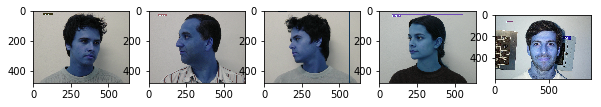

In [12]:
def draw_bbox(x, results):
    '''
    Draws bounding box rectangle and rectangle with class name
    '''
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

draw_time = time.time()

list(map(lambda x: draw_bbox(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(det,x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))
draw_time = time.time() - draw_time

end_time = time.time()

# Plot images
fig = plt.figure(figsize=(10, 10))
n = min(5, len(loaded_ims))
for i in range(n):
    fig.add_subplot(1,n, i + 1)
    plt.imshow(loaded_ims[i])
plt.show()

In [13]:
#TODO keep dituration time, not checkpoints, because jupyter blocks 
print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses",read_dir_time))
print("{:25s}: {:2.3f}".format("Loading batch", load_batch_time))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", det_loop_time))
print("{:25s}: {:2.3f}".format("Output Processing", output_recast_time))
print("{:25s}: {:2.3f}".format("Drawing Boxes", draw_time))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end_time - start_time)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

SUMMARY
----------------------------------------------------------
Task                     : Time Taken (in seconds)

Reading addresses        : 0.002
Loading batch            : 3.025
Detection (229 images)   : 15.407
Output Processing        : 0.136
Drawing Boxes            : 3.417
Average time_per_img     : 0.254
----------------------------------------------------------


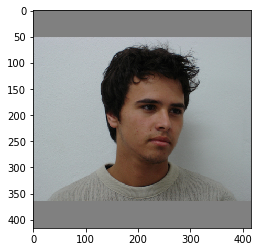

In [8]:
im_batches[0][0].shape
img = im_batches[0][0].cpu().numpy()
img = img.transpose((1,2,0))
plt.imshow(img)